# Import libraries

In [1]:
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as ks
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as xt
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from skimage import io
from glob import glob
from tensorflow.keras.models import Model
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten

# Model

In [2]:
# Define your model architecture

def feature_extractor(inputs):
    x = ks.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(227, 227, 3))(inputs)
    x = ks.layers.AveragePooling2D((2, 2))(x)
    x = ks.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
    x = ks.layers.AveragePooling2D((2, 2))(x)
    x = ks.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
    x = ks.layers.AveragePooling2D((2, 2))(x)
    return x

def dense_layer(inputs):
    x = ks.layers.Flatten()(inputs)
    x = ks.layers.Dense(128, activation='relu')(x)
    return x

def classifier(inputs):
    classifier_output = ks.layers.Dense(6, activation='softmax', name='classifier')(inputs)
    return classifier_output

def bounding_box_regression(inputs):
    bounding_box_regression_output = ks.layers.Dense(4, name='bounding_box')(inputs)
    return bounding_box_regression_output

def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layer(feature_cnn)
    classification_output = classifier(dense_output)
    bounding_box = bounding_box_regression(dense_output)
    
    model = ks.Model(inputs=inputs, outputs=[classification_output, bounding_box])
    
    return model

# Create an instance of the model
inputs = ks.Input(shape=(227, 227, 3))
model = final_model(inputs)

# Compile the model
model.compile(optimizer='adam', loss={'classifier': 'categorical_crossentropy', 'bounding_box': 'mean_squared_error'}, metrics={'classifier': 'accuracy', 'bounding_box': 'mean_squared_error'})

c:\DevOps\Code\test_python\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Load the data and prepare for input

In [3]:
path = sorted(glob('training_images/*.xml'))# get all elements in path with xml extension
y = [] #create a list to store our targets
for file in path:# loop over each file path and parse it
    label = 0
    info = xt.parse(file) 
    root = info.getroot() 
    obj = root.find('object')
    
    label_obj = (obj.find('name').text)

    if "cucumber" in label_obj:  
        label = 1
    elif "eggplant" in label_obj:
        label = 2
    elif "mushroom" in label_obj:
        label = 3
    elif "orange" in label_obj:
        label = 4
    elif "banana" in label_obj:
        label = 5


    bndbox = obj.find('bndbox')
    xmin = (bndbox.find('xmin').text)
    xmax = (bndbox.find('xmax').text)
    ymin = (bndbox.find('ymin').text)
    ymax = (bndbox.find('ymax').text)
    
    #append the results to our target
    y.append([int(label),int(xmin),int(ymin),int(xmax),int(ymax)])



# images 


X = []
images_path = sorted(glob('training_images/*.jpg'))# get all elements in path with jpg extension

for image in images_path:#loop over image path
    img = cv2.imread(image, cv2.COLOR_BGR2RGB)# read the image in rgb mode
    X.append(img)

In [4]:
# check bbox

img_example = X[1]
bbox = y[1][1:]
y[1][1:] #view the bbox coordinates

[121, 0, 226, 114]

In [5]:
# split train test
X = np.array(X)
y =  np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.01)


categ_train = y_train[:,0:1]
categ_test = y_test[:,0:1]
bbox_train = y_train[:,1:]
bbox_test = y_test[:,1:]
categ_train.shape,categ_test.shape,bbox_train.shape,bbox_test.shape

categ_train = tf.keras.utils.to_categorical(categ_train)
categ_test = tf.keras.utils.to_categorical(categ_test)

# Prepare and start training

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

batch_size = 5
steps_per_epoch = 60000 // (batch_size * 5)

# Assuming X_train, categ_train, and bbox_train are already defined
history = model.fit(
    X_train,
    [categ_train, bbox_train],
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    verbose=0
)

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

batch_size = 5
steps_per_epoch = 60000 // (batch_size * 5)

r= model.fit(X_train,[categ_train,bbox_train],epochs=120)

Num GPUs Available:  0
Epoch 1/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - bounding_box_mean_squared_error: 138956.1406 - classifier_accuracy: 0.1764 - loss: 139010.2969
Epoch 2/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - bounding_box_mean_squared_error: 12520.2295 - classifier_accuracy: 0.1625 - loss: 12560.8076
Epoch 3/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - bounding_box_mean_squared_error: 2823.5139 - classifier_accuracy: 0.3078 - loss: 2898.3406
Epoch 4/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - bounding_box_mean_squared_error: 1640.7400 - classifier_accuracy: 0.3158 - loss: 1707.9957
Epoch 5/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - bounding_box_mean_squared_error: 1306.8136 - classifier_accuracy: 0.3301 - loss: 1331.5907
Epoch 6/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - bounding_box_mean_squared_error: 1474.9362 - classifier_accuracy: 0.4077 - loss: 1490.6794
Epoch 7/120
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - bounding_box_mean_squared_error: 906.9014 - classifier

# After training stats

In [8]:
results = pd.DataFrame(r.history)
results.tail()

,bounding_box_mean_squared_error,classifier_accuracy,loss
115,2.382728,0.989899,2.398159
116,2.647137,1.000000,2.655090
117,2.398153,0.994950,2.411394
118,3.682995,0.994950,3.699416
119,2.935527,1.000000,2.948258


In [ ]:
fig = px.line(results,y=[results['classifier_loss'],results['val_classifier_loss']],template="seaborn",color_discrete_sequence=['#05445E','#75E6DA'])
fig.update_layout(   
    title_font_color="#75E6DA", 
    xaxis=dict(color="#75E6DA",title='Epochs'), 
    yaxis=dict(color="#75E6DA")
 )
fig.show()

# Prediction code

In [25]:
def predict(path, model,  threshold, from_url=False):
    """
    passes an image to a trained model and returns annotated image

    Args:
    path:  path containing the image or a list of paths
    model:  pretrained model instance
    from_url: (boolen) to check if the path is a url
    """
    # Check if the path is a list
    if type(path) == list:
        # loop over each path and read the image
        for p in path:
            if from_url:
                image = io.imread(p)
            else:
                image = cv2.imread(p)
    # Check if the type of the path is a string
    elif type(path) == str:
            # read the given image
            if from_url:
                image = io.imread(path)
            else:
                image = cv2.imread(path)
    # Resize the image into the appropriate shape    
    image = cv2.resize(image,(227,227))
    # get model predictions
    categ,bbox = model.predict(np.array([image]))
    # Get class of the highest given probability
    max_prob = np.max(categ)
    categ = np.argmax(categ)
    # flatten the bounding box array and cast it into integer
    bbox = bbox.flatten()
    bbox = bbox.astype(int)
    # draw a rectangle on the image using the predicted bbox coordinates
    image = cv2.rectangle(image,(bbox[0],bbox[1]),(bbox[2],bbox[3]),(255,0,0),1)
    # set prediction class to an empty string
    prediction = ''
    prob = ''
    # set the prediction to the name of the given class according to the model's prediction
    if max_prob >= threshold:
        if categ == 1:
            prediction = 'Kastravec'#'Cucumber'
        elif categ == 2:
            prediction = 'Panxhar'#'Egg Plant'
        elif categ == 3:
            prediction = 'Kerpudhe' #'Mushroom'
        elif categ == 4:
            prediction = 'Portokall'#'orange'
        elif categ == 5:
            prediction = 'banana'
        # elif categ == 3:
        #     prediction = 'Mushroom'
        prob = 'Probability: {:.2f}'.format(max_prob)
    else:
        prediction = 'No object'

    # Put the text of the prediction on the image
    text_x = bbox[0]
    text_y = bbox[1] + 12  # Adjust this value as needed to ensure the text is visible
    final_img = cv2.putText(image,f'{prediction} {prob}',(text_x, text_y),cv2.FONT_HERSHEY_SIMPLEX,0.3,(255,0,0),1,255)
    # Plot the image
    plt.figure(figsize=(6, 6))
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()

# Predict 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


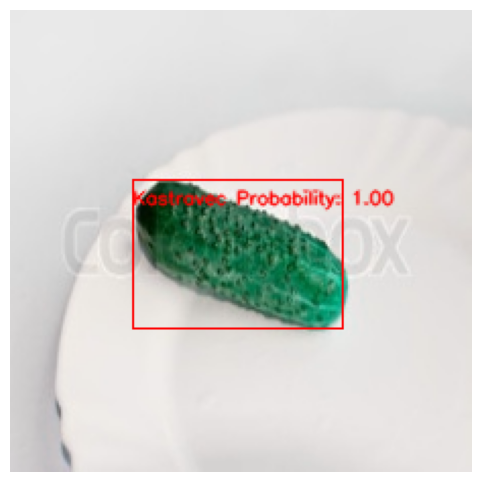

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


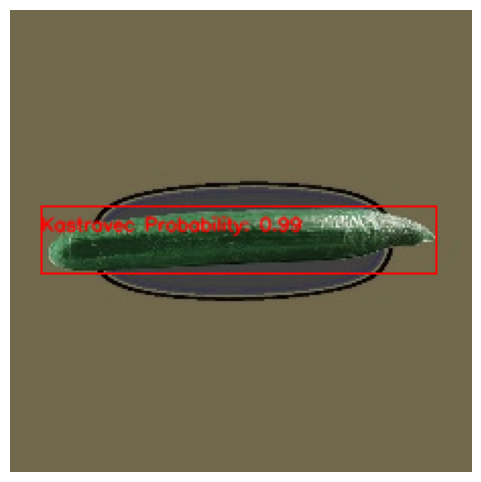

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


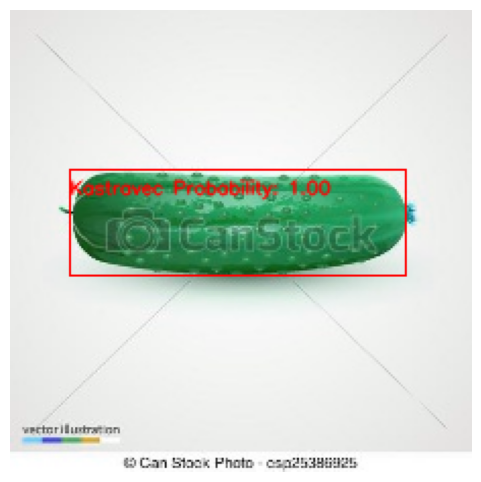

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


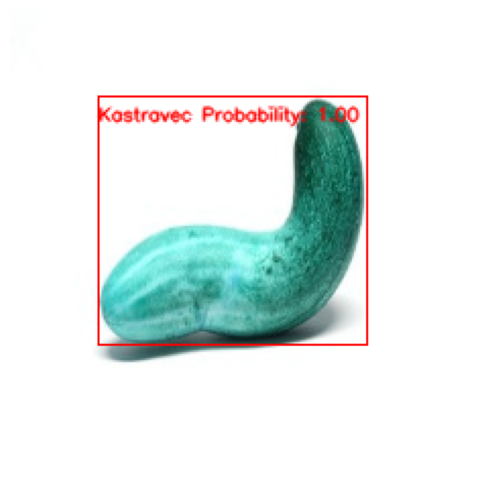

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


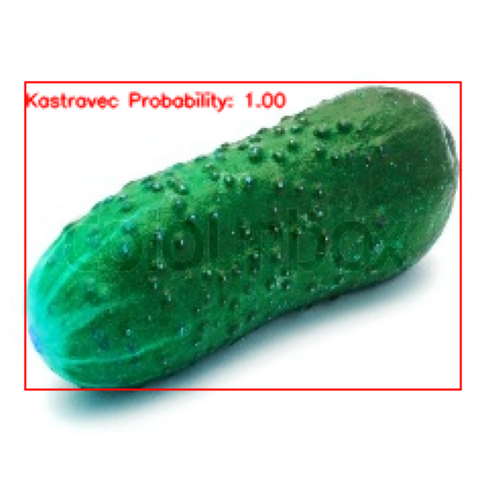

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


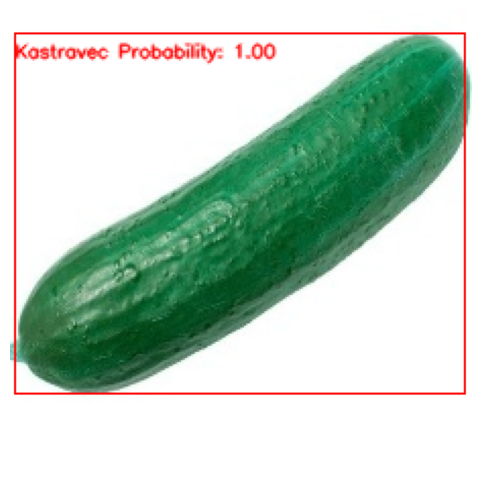

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


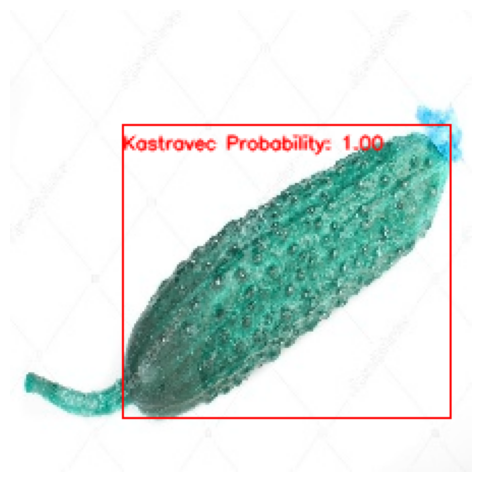

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


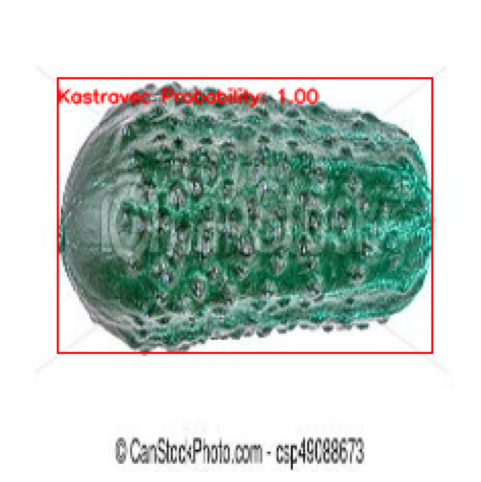

In [29]:
image_directory = 'test'
# Create the list of image file paths
image_paths = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory) if filename.endswith('.jpg')]

for i in range(60,68):
    predict(image_paths[i], model, threshold = 0.5, from_url=False)

In [26]:
predict('image_path',model,True)

AttributeError: 'NoneType' object has no attribute 'shape'